<a href="https://colab.research.google.com/github/Tenntucky/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/Kole_Goldsberry_assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html). Use the scaler's `fit_transform` method with the train set. Use the scaler's `transform` method with the test set.
- [ ] Fit a ridge regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import numpy as np
import pandas_profiling
import seaborn as sns

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)


In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [5]:
df.columns = map(str.lower, df.columns)
df.head()

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,ease-ment,building_class_at_present,address,apartment_number,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price,sale_date
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [0]:
df['sale_date'] = pd.to_datetime(df['sale_date'], infer_datetime_format=True)

In [7]:
subset = df[df['building_class_category'] == '01 ONE FAMILY DWELLINGS']
subset.head(1)

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,ease-ment,building_class_at_present,address,apartment_number,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price,sale_date
7,2,OTHER,01 ONE FAMILY DWELLINGS,1,4090,37,NaN,A1,1193 SACKET AVENUE,NaN,10461.0,1.0,0.0,1.0,"3,404",1328.0,1925.0,1,A1,0,2019-01-01


In [8]:
subset.tail()

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,ease-ment,building_class_at_present,address,apartment_number,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price,sale_date
23029,4,OTHER,01 ONE FAMILY DWELLINGS,1,13215,3,NaN,A2,244-15 135 AVENUE,NaN,11422.0,1.0,0.0,1.0,"3,300",1478.0,1925.0,1,A2,635000,2019-04-30
23031,4,OTHER,01 ONE FAMILY DWELLINGS,1,11612,73,NaN,A1,10919 132ND STREET,NaN,11420.0,1.0,0.0,1.0,"2,400",1280.0,1930.0,1,A1,514000,2019-04-30
23032,4,OTHER,01 ONE FAMILY DWELLINGS,1,11808,50,NaN,A0,135-24 122ND STREET,NaN,11420.0,1.0,0.0,1.0,"4,000",1333.0,1945.0,1,A0,635000,2019-04-30
23033,4,OTHER,01 ONE FAMILY DWELLINGS,1,12295,23,NaN,A1,134-34 157TH STREET,NaN,11434.0,1.0,0.0,1.0,"2,500",1020.0,1935.0,1,A1,545000,2019-04-30
23035,4,OTHER,01 ONE FAMILY DWELLINGS,1,10965,276,NaN,A5,111-17 FRANCIS LEWIS BLVD,NaN,11429.0,1.0,0.0,1.0,"1,800",1224.0,1945.0,1,A5,510000,2019-04-30


In [9]:
import matplotlib.pyplot as plt

# train/test split
# fixing dates, January to March and April
cutoff_date = pd.to_datetime('2019-03-31') 
cutoff_price_low = 100000
cutoff_price_high = 2000000

train = subset[subset['sale_date'] < cutoff_date]
test = subset[subset['sale_date'] > cutoff_date]

train = train[train['sale_price'] > cutoff_price_low]
test = test[test['sale_price'] > cutoff_price_low]

train = train[train['sale_price'] < cutoff_price_high]
test = test[test['sale_price'] < cutoff_price_high]

print(train.shape, test.shape)

(2507, 21) (644, 21)


In [10]:
train.select_dtypes(exclude='number').describe().T

,count,unique,top,freq,first,last
borough,2507,5,4,1204,NaT,NaT
neighborhood,2507,6,OTHER,2382,NaT,NaT
building_class_category,2507,1,01 ONE FAMILY DWELLINGS,2507,NaT,NaT
tax_class_at_present,2507,2,1,2476,NaT,NaT
building_class_at_present,2507,13,A1,919,NaT,NaT
address,2507,2497,33 BAILEY PLACE,2,NaT,NaT
apartment_number,1,1,RP.,1,NaT,NaT
land_square_feet,2507,887,"4,000",234,NaT,NaT
building_class_at_time_of_sale,2507,11,A1,919,NaT,NaT
sale_date,2507,68,2019-01-31 00:00:00,78,2019-01-01,2019-03-30


In [11]:
train.groupby('neighborhood')['sale_price'].mean()


neighborhood
ASTORIA               1.001955e+06
BEDFORD STUYVESANT    6.215972e+05
BOROUGH PARK          1.008917e+06
FLUSHING-NORTH        8.689417e+05
FOREST HILLS          1.210753e+06
OTHER                 6.056645e+05
Name: sale_price, dtype: float64

In [0]:
target = 'sale_price'
high_cardinality = ['building_class_at_present', 'address', 'land_square_feet', 'sale_date', 'apartment_number', 'ease-ment']
features = train.columns.drop([target] + high_cardinality)

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]


In [13]:
print(X_train.shape)
X_train.head(3)

(2507, 14)


,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,zip_code,residential_units,commercial_units,total_units,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,11230.0,1.0,0.0,1.0,1325.0,1930.0,1,A9
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,11427.0,1.0,0.0,1.0,2001.0,1940.0,1,A1
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,10461.0,1.0,0.0,1.0,2043.0,1925.0,1,A1


In [0]:
import category_encoders as ce 

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [15]:
X_train.head()

,borough_3,borough_4,borough_2,borough_5,borough_1,neighborhood_OTHER,neighborhood_FLUSHING-NORTH,neighborhood_BEDFORD STUYVESANT,neighborhood_FOREST HILLS,neighborhood_BOROUGH PARK,neighborhood_ASTORIA,building_class_category_01 ONE FAMILY DWELLINGS,tax_class_at_present_1,tax_class_at_present_1D,block,lot,zip_code,residential_units,commercial_units,total_units,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale_A9,building_class_at_time_of_sale_A1,building_class_at_time_of_sale_A5,building_class_at_time_of_sale_A0,building_class_at_time_of_sale_A2,building_class_at_time_of_sale_A3,building_class_at_time_of_sale_S1,building_class_at_time_of_sale_A4,building_class_at_time_of_sale_A6,building_class_at_time_of_sale_A8,building_class_at_time_of_sale_S0
44,1,0,0,0,0,1,0,0,0,0,0,1,1,0,5495,801,11230.0,1.0,0.0,1.0,1325.0,1930.0,1,1,0,0,0,0,0,0,0,0,0,0
61,0,1,0,0,0,1,0,0,0,0,0,1,1,0,7918,72,11427.0,1.0,0.0,1.0,2001.0,1940.0,1,0,1,0,0,0,0,0,0,0,0,0
78,0,0,1,0,0,1,0,0,0,0,0,1,1,0,4210,19,10461.0,1.0,0.0,1.0,2043.0,1925.0,1,0,1,0,0,0,0,0,0,0,0,0
108,1,0,0,0,0,1,0,0,0,0,0,1,1,0,5212,69,11226.0,1.0,0.0,1.0,2680.0,1899.0,1,0,1,0,0,0,0,0,0,0,0,0
111,1,0,0,0,0,1,0,0,0,0,0,1,1,0,7930,121,11203.0,1.0,0.0,1.0,1872.0,1940.0,1,0,0,1,0,0,0,0,0,0,0,0


In [16]:
X_train.shape

(2507, 34)

In [17]:
from sklearn.feature_selection import f_regression, SelectKBest

selector = SelectKBest(score_func=f_regression, k=15)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
X_train_selected.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


(2507, 15)

In [18]:
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features Selected:')
for name in selected_names:
  print(name)

print('')
print('Features Not Selected:')
for name in unselected_names:
  print(name)

Features Selected:
borough_3
borough_2
borough_5
neighborhood_OTHER
neighborhood_FLUSHING-NORTH
neighborhood_FOREST HILLS
block
zip_code
commercial_units
total_units
gross_square_feet
building_class_at_time_of_sale_A5
building_class_at_time_of_sale_A3
building_class_at_time_of_sale_S1
building_class_at_time_of_sale_A6

Features Not Selected:
borough_4
borough_1
neighborhood_BEDFORD STUYVESANT
neighborhood_BOROUGH PARK
neighborhood_ASTORIA
building_class_category_01 ONE FAMILY DWELLINGS
tax_class_at_present_1
tax_class_at_present_1D
lot
residential_units
year_built
tax_class_at_time_of_sale
building_class_at_time_of_sale_A9
building_class_at_time_of_sale_A1
building_class_at_time_of_sale_A0
building_class_at_time_of_sale_A2
building_class_at_time_of_sale_A4
building_class_at_time_of_sale_A8
building_class_at_time_of_sale_S0


In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train.columns) + 1):
  print(f'{k} features:')

  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)

  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_test_selected)

  mae = mean_absolute_error(y_test, y_pred)
  print(f'Test MAE: ${mae:,.0f}\n')

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

1 features:
Test MAE: $183,641

2 features:
Test MAE: $182,569

3 features:
Test MAE: $173,706

4 features:
Test MAE: $174,556

5 features:
Test MAE: $172,843

6 features:
Test MAE: $173,412

7 features:
Test MAE: $173,241

8 features:
Test MAE: $168,668

9 features:
Test MAE: $169,452

10 features:
Test MAE: $169,006

11 features:
Test MAE: $161,221

12 features:
Test MAE: $162,578

13 features:


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in 

Test MAE: $161,734

14 features:
Test MAE: $161,547

15 features:
Test MAE: $161,307

16 features:
Test MAE: $159,302

17 features:
Test MAE: $159,371

18 features:
Test MAE: $159,371

19 features:
Test MAE: $159,371

20 features:
Test MAE: $159,093

21 features:
Test MAE: $158,972

22 features:
Test MAE: $158,905

23 features:
Test MAE: $159,704

24 features:
Test MAE: $159,755

25 features:


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

Test MAE: $159,333

26 features:
Test MAE: $159,336

27 features:
Test MAE: $158,991

28 features:
Test MAE: $159,765

29 features:
Test MAE: $159,194

30 features:
Test MAE: $159,179

31 features:
Test MAE: $159,179

32 features:
Test MAE: $159,179

33 features:
Test MAE: $159,179

34 features:
Test MAE: $159,179



/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in 

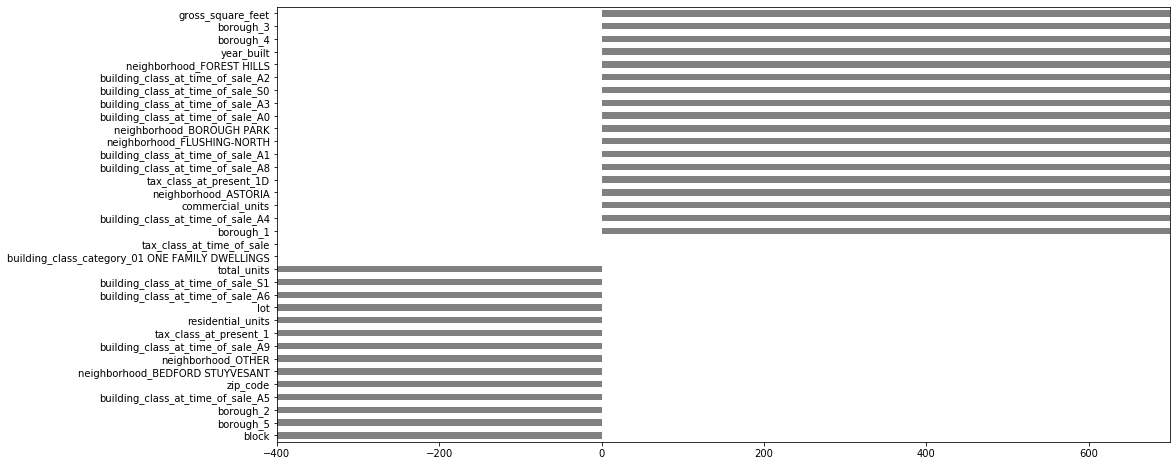

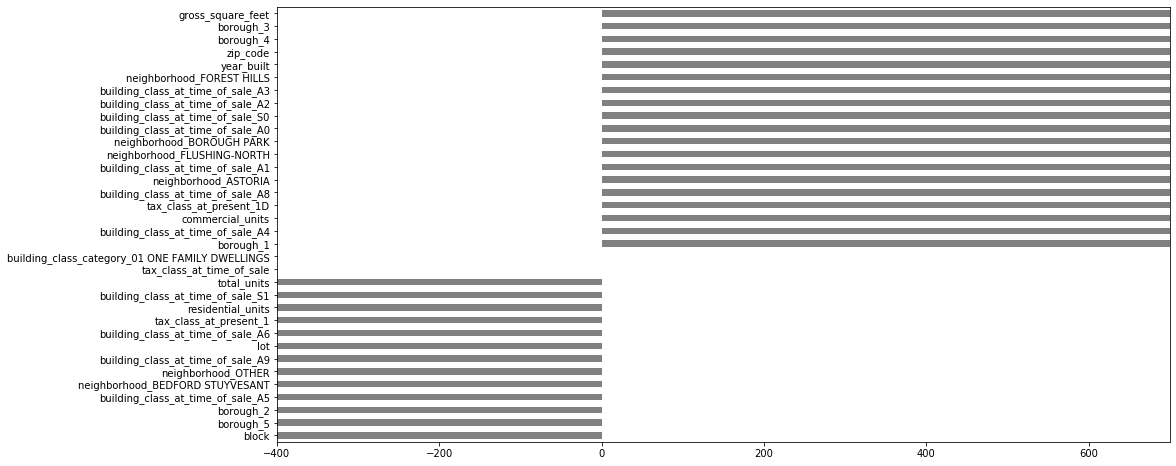

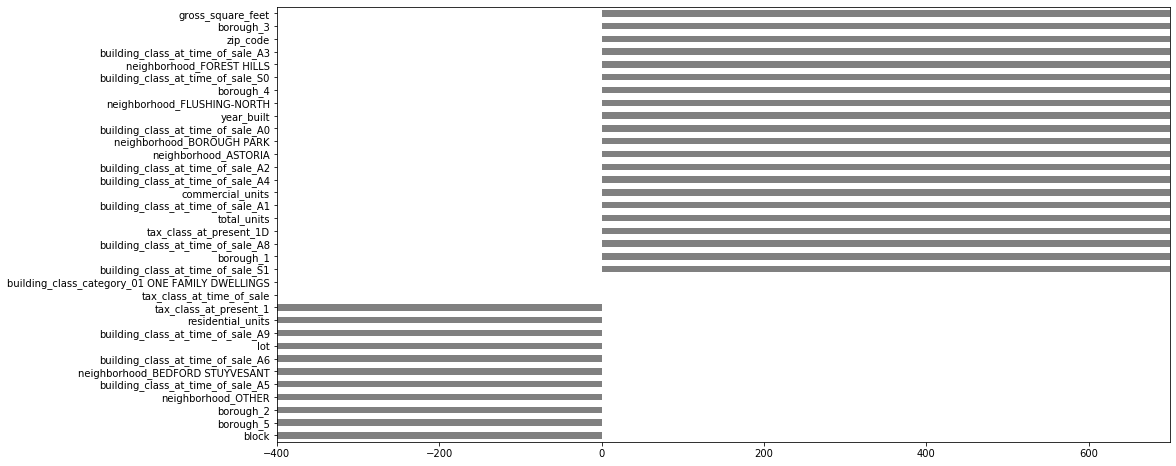

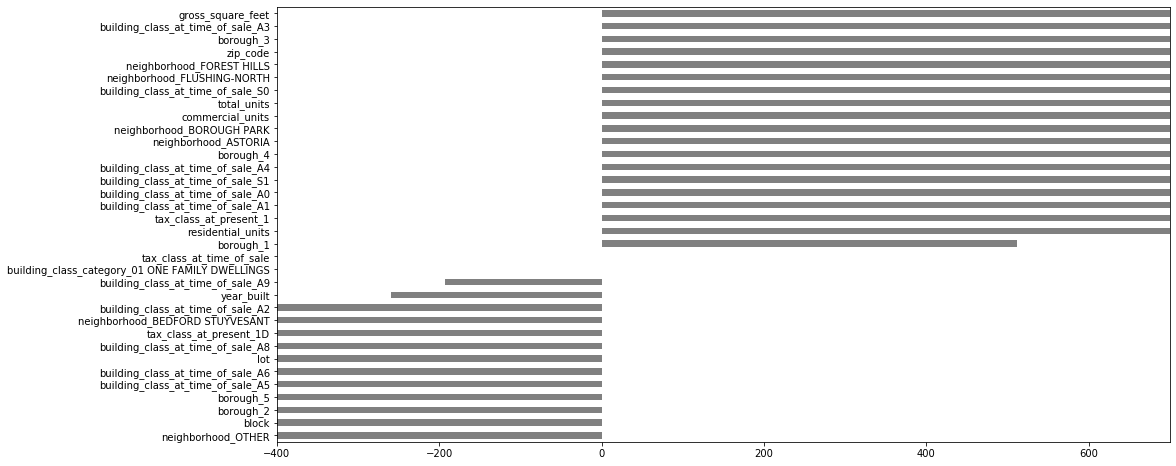

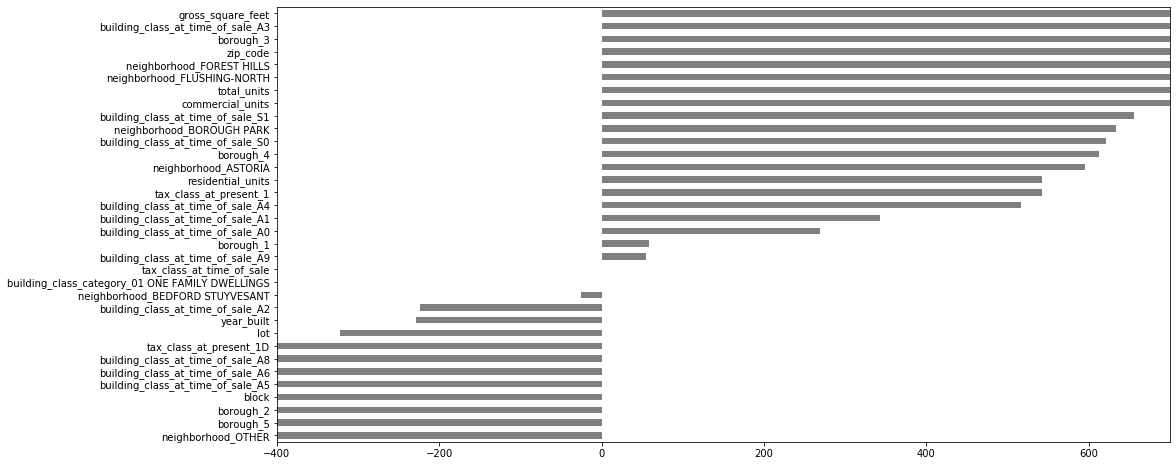

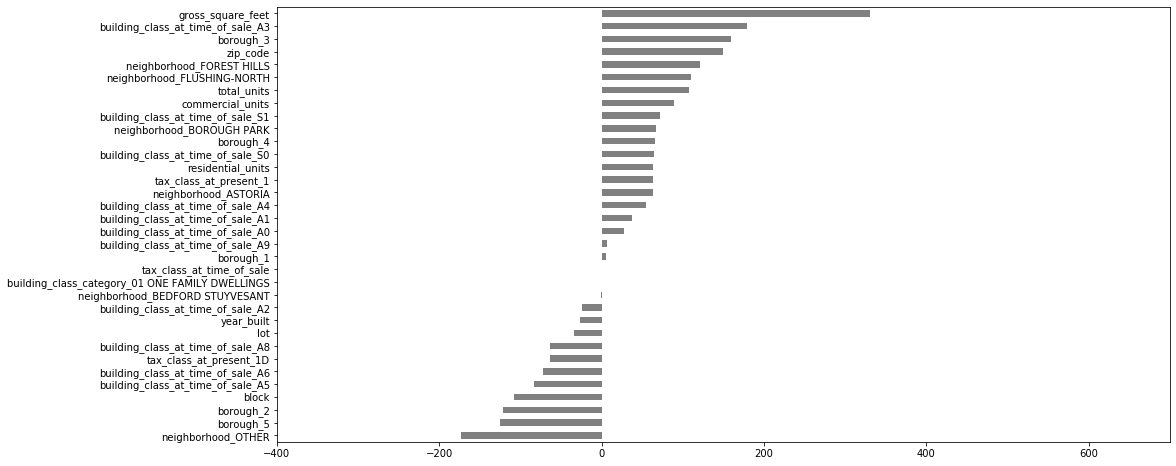

In [21]:
%matplotlib inline
from IPython.display import display, HTML
from ipywidgets import interact
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

for alpha in [10**1, 10**2, 10**3, 10**4, 10**5, 10**6]:

  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  display(HTML(f'Ridge Regression, with alpha={alpha}'))
  model = Ridge(alpha=alpha)
  model.fit(X_train_scaled, y_train)
  y_pred = model.predict(X_test_scaled)

  mae = mean_absolute_error(y_test, y_pred)
  display(HTML(f'Test Mean Absolute Error: $ {mae:,.0f}'))

  coefficients = pd.Series(model.coef_, X_train.columns)
  plt.figure(figsize=(16,8))
  coefficients.sort_values().plot.barh(color='grey')
  plt.xlim(-400,700)
  plt.show()

In [0]:
from sklearn.model_selection import train_test_split

In [28]:
from sklearn.metrics import mean_squared_error

alphas = []
mses = []

for alpha in range(0, 200, 1):
  ridge_reg_split = Ridge(alpha=alpha).fit(X_train, y_train)
  mse = mean_squared_error(y_test, ridge_reg_split.predict(X_test))
  print(alpha, mse)
  alphas.append(alpha)
  mses.append(mse)

0 3.8509102985072135e+29
1 53794131212.29695
2 53850843872.89144
3 53913009306.92893
4 53977364537.45642
5 54041897540.85856
6 54105429779.01472
7 54167293819.15196
8 54227132399.45029
9 54284776898.6899
10 54340173558.587585
11 54393338180.20953
12 54444327971.350395
13 54493223880.651146
14 54540119443.48777
15 54585113729.17784
16 54628306903.0552
17 54669797472.13588
18 54709680622.45997
19 54748047267.0711
20 54784983556.649506
21 54820570689.93604
22 54854884916.23362
23 54887997658.39909
24 54919975708.63519
25 54950881465.33116
26 54980773189.90323
27 55009705269.810234
28 55037728478.81293
29 55064890228.86402
30 55091234810.265045
31 55116803618.24488
32 55141635365.13232
33 55165766277.966156
34 55189230281.82439
35 55212059169.42352
36 55234282757.7028
37 55255929032.18999
38 55277024279.981606
39 55297593212.16778
40 55317659076.50974
41 55337243761.14425
42 55356367890.0412
43 55375050910.897224
44 55393311176.095604
45 55411166017.31684
46 55428631814.33485
47 5544572405

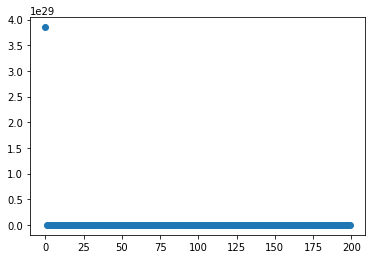

In [29]:
plt.scatter(alphas, mses)